# Import Library and Define Functions

In [1]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 13.7 MB/s eta 0:00:00


In [2]:
!pip install hoggorm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.3 MB/s eta 0:00:00


In [3]:
!pip install scikit-bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 27.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 45.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.0 MB/s eta 0:00:00
  Created wheel for scikit-bio: filename=scikit_bio-0.5.9-cp310-cp310-linux_x86_64.whl size=2469063 sha256=a7be5f7232e0256bf95bb4a9475fd2e68eb7a223cc4583c3a428eda2f12df23b
  Stored in directory: /root/.cache/pip/wheels/77/72/2c/993efbb4d69a86bee422bc96e4e2f1ec9af7cc596a08bb86e1
  Created wheel for hdmedians: filename=hdmedians-0.14.2-cp310-cp310-linux_x86_64.whl size=677995 sha256=6af437a765b14fa4d8e89079046258ed9fe7d3416e71f9a6353fb0fafd11c45f

In [4]:
import os
import numpy as np
import os
import shutil
np.random.seed(42)

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
import ot
import warnings
import scipy.stats as sps
import scipy.linalg as spl
from scipy.optimize import linprog
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


Define All relevant functions

In [5]:

def GW2(pi0,pi1,mu0,mu1,S0,S1):
    # return the GW2 discrete map and the GW2 distance between two GMM
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    M  = np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    # Then we compute the OT distance or OT map thanks to the OT library
    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan
    distGW2   = np.sum(wstar*M)
    return wstar,distGW2

def GW2cost(mu0,mu1,S0,S1):       # return the distance matrix M of size K0 x K1
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    M = np.zeros((K0,K1))
    # we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    return M


def GaussianW2(m0,m1,Sigma0,Sigma1):
    # compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d


# ... (existing definitions and previous code)
def remove_outliers_with_isolation_forest(data):
    clf = IsolationForest(contamination=0.05)
    preds = clf.fit_predict(data)
    return data[preds == 1]

def compute_gmm_wasserstein_distance(means_list, covariances_list, densities_list, proportions_list):
    num_datasets = len(means_list)
    wasserstein_distances = np.zeros((num_datasets, num_datasets))

    for idx_i in range(num_datasets):
        for idx_j in range(idx_i + 1, num_datasets):
            print(f"\nComparing Dataset {idx_i+1} with Dataset {idx_j+1}:")

            all_weights_i = []
            all_orig_densities_i = []
            all_mod_densities_i = []
            all_weights_j = []
            all_orig_densities_j = []
            all_mod_densities_j = []

            for k in range(len(proportions_list[idx_i])):
                orig_pi0 = np.array(densities_list[idx_i][k])
                mod_pi0 = orig_pi0 * proportions_list[idx_i][k]
                all_weights_i.append(proportions_list[idx_i][k])
                all_orig_densities_i.append(orig_pi0)
                all_mod_densities_i.append(mod_pi0)

            for l in range(len(proportions_list[idx_j])):
                orig_pi1 = np.array(densities_list[idx_j][l])
                mod_pi1 = orig_pi1 * proportions_list[idx_j][l]
                all_weights_j.append(proportions_list[idx_j][l])
                all_orig_densities_j.append(orig_pi1)
                all_mod_densities_j.append(mod_pi1)

            # print("Original weights and densities for Dataset", idx_i+1)
            # for w, d in zip(all_weights_i, all_orig_densities_i):
            #     print(f"Weight: {w}, Density: {d}")

            # print("\nModified weights and densities for Dataset", idx_i+1)
            # for w, d in zip(all_weights_i, all_mod_densities_i):
            #     print(f"Weight: {w}, Density: {d}")

            # print("\nOriginal weights and densities for Dataset", idx_j+1)
            # for w, d in zip(all_weights_j, all_orig_densities_j):
            #     print(f"Weight: {w}, Density: {d}")

            # print("\nModified weights and densities for Dataset", idx_j+1)
            # for w, d in zip(all_weights_j, all_mod_densities_j):
            #     print(f"Weight: {w}, Density: {d}")


            combined_pi0 = np.concatenate(all_mod_densities_i )
            combined_pi0 /= combined_pi0.sum()
            combined_pi1 = np.concatenate(all_mod_densities_j)
            combined_pi1 /= combined_pi1.sum()

            combined_mu0 = np.concatenate([means_list[idx_i][k] for k in range(len(proportions_list[idx_i]))])
            combined_mu1 = np.concatenate([means_list[idx_j][l] for l in range(len(proportions_list[idx_j]))])
            combined_Sigma0 = np.concatenate([covariances_list[idx_i][k] for k in range(len(proportions_list[idx_i]))])
            combined_Sigma1 = np.concatenate([covariances_list[idx_j][l] for l in range(len(proportions_list[idx_j]))])

            # print(f"\nModified weights for Dataset {idx_i+1}: {combined_pi0}")
            # print(f"Modified weights for Dataset {idx_j+1}: {combined_pi1}")

            if combined_pi0.sum() > 0 and combined_pi1.sum() > 0:
                _, distGW2 = GW2(combined_pi0, combined_pi1, combined_mu0, combined_mu1, combined_Sigma0, combined_Sigma1)
                # print(f"\nWasserstein Distance between Dataset {idx_i+1} and Dataset {idx_j+1}: {distGW2}")
                wasserstein_distances[idx_i, idx_j] = distGW2
                wasserstein_distances[idx_j, idx_i] = distGW2
                # print("-" * 50)

    return wasserstein_distances

# Store GMM parameters and proportions for each group
def choose_num_components(count):
        return 6

def calculate_gw2_distance(sources, params, df):
    """
    Calculate the GW2 distance between sources.

    Parameters:
    sources (list): List of source names.
    params (dict): Dictionary containing GMM parameters.
    df (pandas.DataFrame): DataFrame containing cell types.
    GW2 (function): Function to calculate GW2 distance.

    Returns:
    np.ndarray: Distance matrix containing GW2 distances between sources.
    """
    num_sources = len(sources)
    distance_matrix = np.zeros((num_sources, num_sources))

    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            if i < j:
                means1 = np.concatenate([params[(source1, cell_type)]['means']
                                         for cell_type in df['cluster'].unique()
                                         if (source1, cell_type) in params])

                means2 = np.concatenate([params[(source2, cell_type)]['means']
                                         for cell_type in df['cluster'].unique()
                                         if (source2, cell_type) in params])

                covs1 = np.concatenate([params[(source1, cell_type)]['covariances']
                                        for cell_type in df['cluster'].unique()
                                        if (source1, cell_type) in params])

                covs2 = np.concatenate([params[(source2, cell_type)]['covariances']
                                        for cell_type in df['cluster'].unique()
                                        if (source2, cell_type) in params])

                weights1 = np.concatenate([params[(source1, cell_type)]['weights'] * params[(source1, cell_type)]['proportion']
                                           for cell_type in df['cluster'].unique()
                                           if (source1, cell_type) in params])
                weights2 = np.concatenate([params[(source2, cell_type)]['weights'] * params[(source2, cell_type)]['proportion']
                                           for cell_type in df['cluster'].unique()
                                           if (source2, cell_type) in params])

                weights1 = weights1 / np.sum(weights1)
                weights2 = weights2 / np.sum(weights2)

                if len(means1) > 0 and len(means2) > 0 and len(weights1) > 0 and len(weights2) > 0:
                    _, distGW2 = GW2(weights1, weights2, means1, means2, covs1, covs2)
                    distance_matrix[i, j] = distGW2
                    distance_matrix[j, i] = distGW2

    return distance_matrix

def normalize(data, column):
    df_normalize = data[column]
    min = df_normalize.min()
    max = df_normalize.max()
    df_normalize = (df_normalize-min)/(max-min)
    return df_normalize
def matrix_plot(data_df_selected, x_axis, y_axis, pad_number = 100):
    density = np.zeros((101,101))

    data_df_selected = data_df_selected.round(0)
    data_df_selected_count = data_df_selected.groupby([x_axis, y_axis]).size().reset_index(name="count")

    coord = data_df_selected_count[[x_axis, y_axis]]
    coord = coord.to_numpy().round(0).astype(int).T

    replace = data_df_selected_count[['count']].to_numpy()

    coord = list(zip(coord[0], coord[1], replace.reshape(-1).tolist()))

    return coord
def export_matrix(file, x_axis, y_axis):

    data_df_selected = file[[x_axis, y_axis]].copy()

    data_df_selected.loc[:, x_axis] = normalize(data_df_selected, x_axis) * 100
    data_df_selected.loc[:, y_axis] = normalize(data_df_selected, y_axis) * 100

    coord = matrix_plot(data_df_selected, x_axis, y_axis, 0)

    return coord


# Function to compute the RV coefficient
def rv_coefficient(X, Y):
    XX = np.cov(X, rowvar=False)
    YY = np.cov(Y, rowvar=False)
    XY = np.cov(X, Y, rowvar=False)[:X.shape[1], X.shape[1]:]

    rv = np.trace(XY @ XY.T) / (np.trace(XX @ XX.T) * np.trace(YY @ YY.T))**0.5
    return rv
def normalize_matrix(mat):
    min_val = np.min(mat)
    max_val = np.max(mat)
    range_val = max_val - min_val
    if range_val == 0:
        return mat - min_val
    else:
        return (mat - min_val) / range_val

# Read in Data and Visualization

In [6]:
df = pd.read_csv('/content/QOT_Simulation.csv')

Visualization of Simulation Data


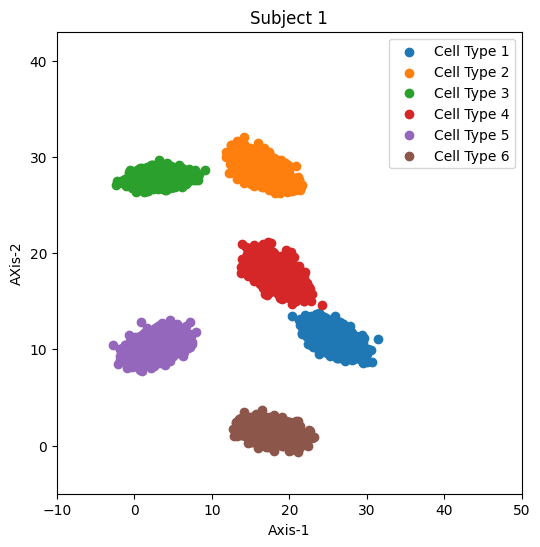

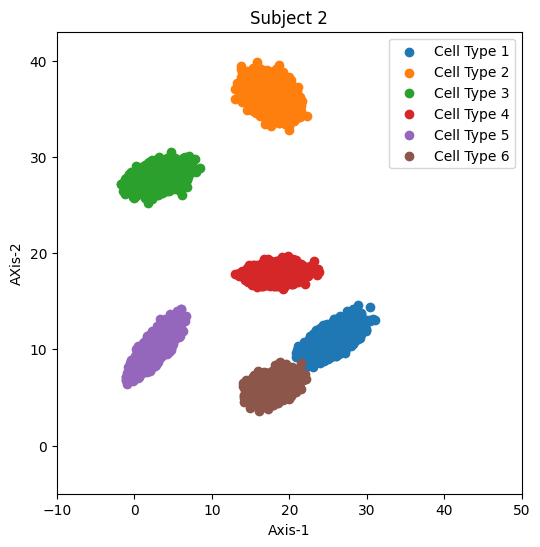

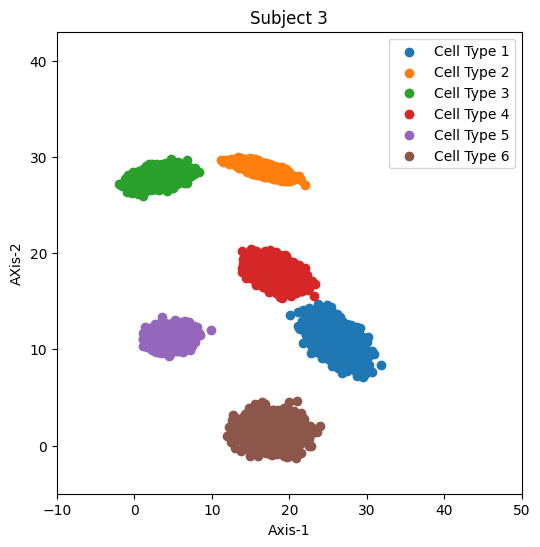

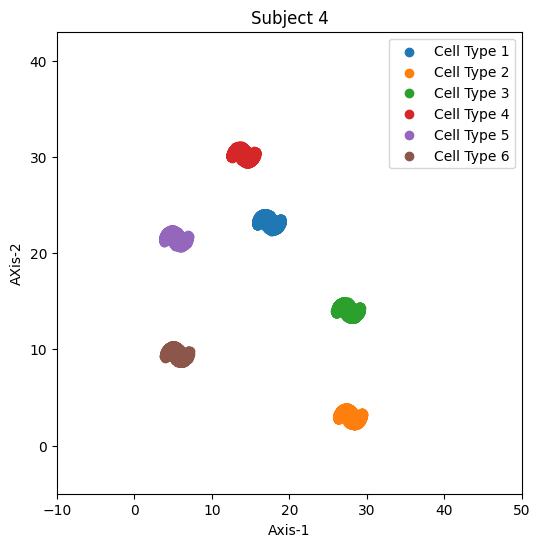

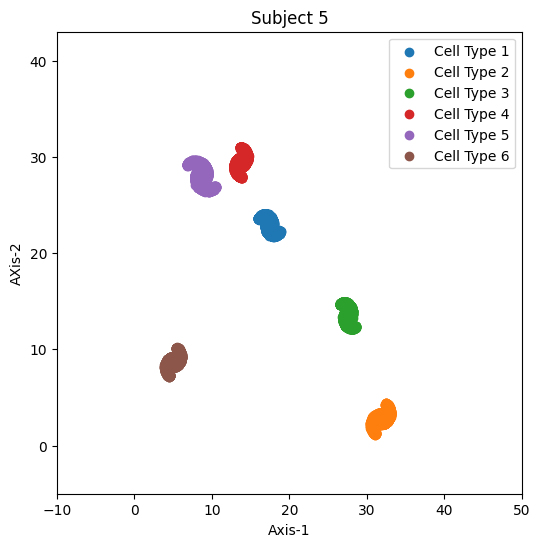

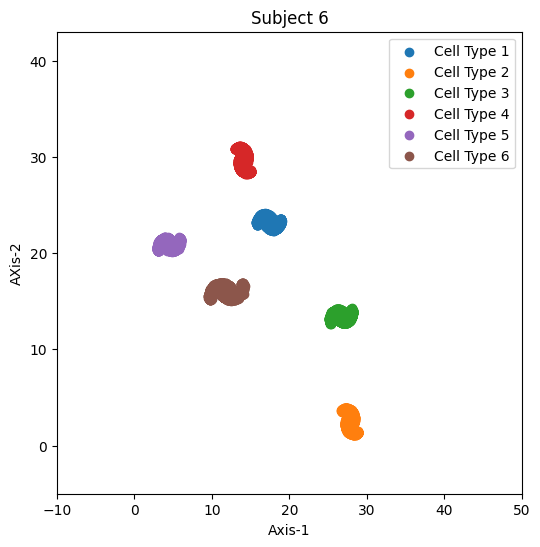

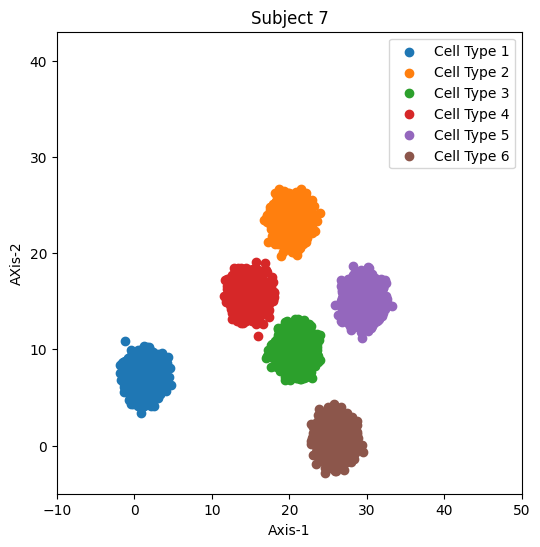

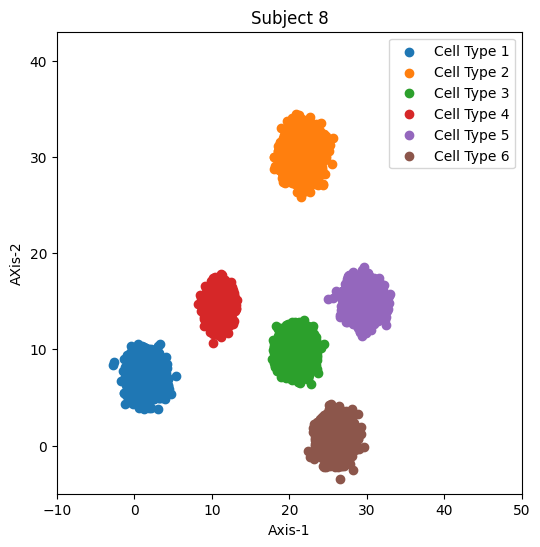

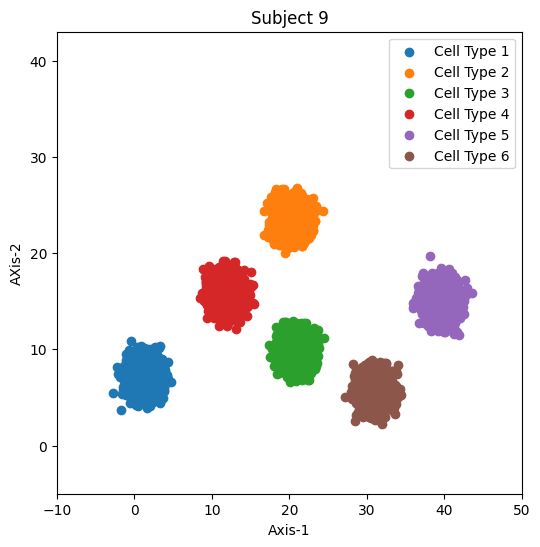

In [7]:
n_dataframes = 9
print("Visualization of Simulation Data")
for i in range(1, n_dataframes + 1):
    df_to_plot = df[df['SourceDataFrame'] == i]
    plt.figure(figsize=(6, 6))

    # Create an empty list to collect the scatter plot objects for the legend
    scatters = []
    labels = []

    for j in range(df_to_plot['cluster'].nunique()):
        cluster_data = df_to_plot[df_to_plot['cluster'] == j]
        scatter = plt.scatter(cluster_data['feature_1'], cluster_data['feature_2'],
                              cmap=plt.cm.rainbow, label=f'Cell {j+1}')
        scatters.append(scatter)
        labels.append(f'Cell Type {j+1}')

    plt.title(f"Subject {i}")
    plt.xlabel('Axis-1')
    plt.ylabel('AXis-2')
    plt.xlim(-10, 50)
    plt.ylim(-5, 43)

    # Add legend
    legend = plt.legend(handles=scatters, labels=labels, loc='upper right')

    plt.show()

#Proposed QOT-Ctyo

In [8]:
# Main loop
import time
final_df= df

start_time = time.time()

#final_df_filtered = final_df_filtered[final_df_filtered['cell_type'] != 'Unknown']

grouped = final_df.groupby(['SourceDataFrame', 'cluster'])
df=final_df
gmm_count_per_source = {}

params = {}
for (source, label), group in grouped:
    data = group.drop(['SourceDataFrame', 'label',  'cluster'], axis=1)
    num_samples = data.shape[0]

    # Choose the number of GMM components based on the number of samples
    num_components = choose_num_components(num_samples)
    gmm_count_per_source[source] = gmm_count_per_source.get(source, 0) + num_components
    if num_samples >= num_components:  # Ensure there are enough samples
        gmm = GaussianMixture(n_components=num_components, random_state=0).fit(data)

        key = (source, label)
        params[key] = {
            'means': gmm.means_,
            'covariances': gmm.covariances_,
            'weights': gmm.weights_,
            'proportion': len(group) / len(df[df['SourceDataFrame'] == source])
        }
    #     print(f"Processed source {source}, label {label}, number of samples {num_samples}, number of components {num_components}")

    # else:
    #     print(f"Skipped source {source}, label {label}, number of samples {num_samples} - not enough data for {num_components} components")
# for source, count in gmm_count_per_source.items():
#     print(f"SourceDataFrame {source} has a total of {count} GMM components across all labels.")



sources = df['SourceDataFrame'].unique()
qot_labeled = np.zeros((len(sources), len(sources)))
qot_labeled = calculate_gw2_distance(sources, params, df)
end_time = time.time()
qot_execution_time = end_time - start_time
print(f"The QOT-Labled executed in {qot_execution_time} seconds.")
print("QOT-Labled Complete")

The QOT-Labled executed in 38.059041023254395 seconds.
QOT-Labled Complete


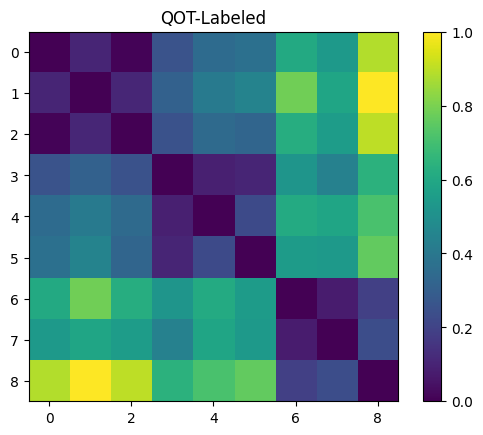

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap using seaborn
# Plot heatmap
qot_labeled= normalize_matrix(qot_labeled)
plt.imshow(qot_labeled, cmap='viridis', interpolation='none')
plt.title("QOT-Labeled")
plt.colorbar()

# Set the title and display the heatmap

plt.show()

# Exact WD

In [10]:
import pandas as pd
import numpy as np
from ot import emd2
from itertools import combinations
import ot
import time
import pandas as pd
import numpy as np
from ot import emd2, dist


feature_columns = df.columns[:-3]
sampled_df = df

# Calculate pairwise Wasserstein distances between different SourceDataFrame groups
n = len(sampled_df['SourceDataFrame'].unique())
exact_mtx= np.zeros((n, n))
start_time = time.time()
for i in range(1, n+1):
    for j in range(i+1, n+1):
        group1 = sampled_df[sampled_df['SourceDataFrame'] == i][feature_columns].values
        group2 = sampled_df[sampled_df['SourceDataFrame'] == j][feature_columns].values

        M = dist(group1, group2)
        a = np.ones((M.shape[0],)) / M.shape[0]
        b = np.ones((M.shape[1],)) / M.shape[1]
        distance = emd2(a, b, M)

        exact_mtx[i-1, j-1] = distance
        exact_mtx[j-1, i-1] = distance  # The distance matrix is symmetric


end_time = time.time()
# Calculate and print the execution time
exact_execution_time = end_time - start_time
print(f"The Exact WD executed in {exact_execution_time} seconds.")
print("Exact WD Complete")

The Exact WD executed in 2857.7544882297516 seconds.
Exact WD Complete


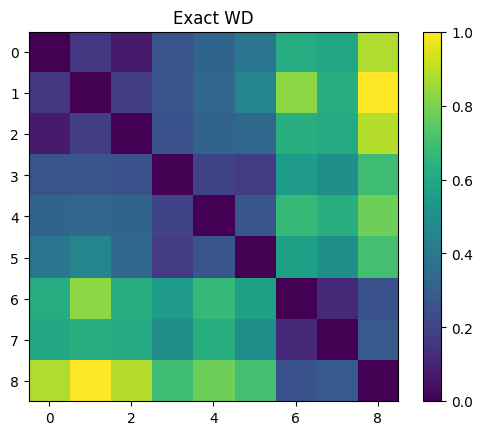

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap using seaborn
# Plot heatmap
exact_mtx= normalize_matrix(exact_mtx)
plt.imshow(exact_mtx, cmap='viridis', interpolation='none')
plt.title("Exact WD")
plt.colorbar()

# Set the title and display the heatmap

plt.show()

# Image Based WD

In [12]:

coord_list = []
num_subj = df.SourceDataFrame.unique().shape[0]

start_time = time.time()
for i in range(num_subj):
    tmp = df[df['SourceDataFrame']==(i+1)]
    coord = export_matrix(tmp, 'feature_1', 'feature_2')
    coord = np.array(coord)
    coord_list.append(coord)
num_subj = len(coord_list)
image_mtx = np.zeros((num_subj, num_subj))
for i in range(num_subj):
    for j in range(num_subj):

        if i>=j:
            continue

        subject1 = coord_list[i]
        subject2 = coord_list[j]

        coord1 = subject1[:,0:2]
        coord2 = subject2[:,0:2]

        mass1 = subject1[:,2]
        mass2 = subject2[:,2]

        mass1 = mass1/mass1.sum()*1000 # normalize but prevent too small
        mass2 = mass2/mass2.sum()*1000

        M = ot.dist(coord1, coord2)

        dist = ot.emd2(mass1, mass2, M)

        image_mtx[i,j] = dist
        image_mtx[j,i] = dist

end_time = time.time()
Image_execution_time = end_time - start_time
print(f"The Exact WD executed in {Image_execution_time} seconds.")
print("Image Based Complete")

The Exact WD executed in 11.83421277999878 seconds.
Image Based Complete


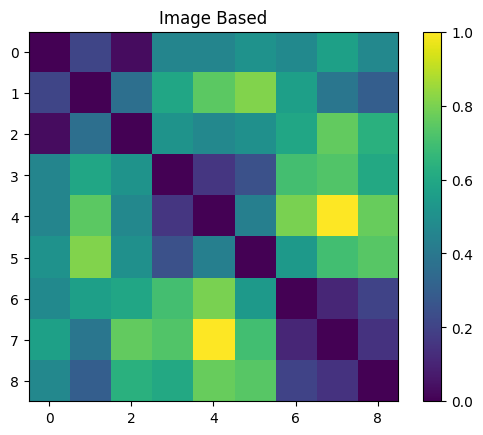

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap using seaborn
# Plot heatmap
image_mtx= normalize_matrix(image_mtx)
plt.imshow(image_mtx, cmap='viridis', interpolation='none')
plt.title("Image Based")
plt.colorbar()

# Set the title and display the heatmap

plt.show()

# Calculate Relavent Metrix and Summarized

Time

In [14]:
print(f"The Exact WD executed in {exact_execution_time} seconds.")
print(f"The Exact WD executed in {Image_execution_time} seconds.")
print(f"The QOT-Labled executed in {qot_execution_time} seconds.")

The Exact WD executed in 2857.7544882297516 seconds.
The Exact WD executed in 11.83421277999878 seconds.
The QOT-Labled executed in 38.059041023254395 seconds.


Silhouette Score

In [15]:
labels = np.concatenate((np.zeros(3, dtype=int), np.ones(3, dtype=int),2*np.ones(3, dtype=int)))

# Calculate silhouette score from the distance matrix and given labels
score = silhouette_score(exact_mtx, labels, metric='precomputed')
# Print silhouette score
print(f"Silhouette Score for Exact WD: {score}")

# Calculate silhouette score from the distance matrix and given labels
score = silhouette_score(image_mtx, labels, metric='precomputed')
# Print silhouette score
print(f"Silhouette Score for Image Based: {score}")

# Calculate silhouette score from the distance matrix and given labels
score = silhouette_score(qot_labeled, labels, metric='precomputed')
# Print silhouette score
print(f"Silhouette Score for Qot_Labeled: {score}")

Silhouette Score for Exact WD: 0.5204246505154619
Silhouette Score for Image Based: 0.5883190529476799
Silhouette Score for Qot_Labeled: 0.7010371775589719


Mantel Test

In [16]:
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import mantel

# Computing distance matrices
mat1 = exact_mtx # Replace with actual data
mat2 = image_mtx


# Performing Mantel test
correlation, p_value, _ = mantel(mat1, mat2, method='pearson', permutations=999)

print(f'Mantel Correlation Between Exact WD and Image Based: {correlation}')
print(f'P-value: {p_value}')

# Computing distance matrices
mat1 = exact_mtx # Replace with actual data
mat2 = qot_labeled

# Performing Mantel test
correlation, p_value, _ = mantel(mat1, mat2, method='pearson', permutations=999)

print(f'Mantel Correlation Between Exact WD and Image Based: {correlation}')
print(f'P-value: {p_value}')

Mantel Correlation Between Exact WD and Image Based: 0.538378736723888
P-value: 0.007
Mantel Correlation Between Exact WD and Image Based: 0.9866320771078473
P-value: 0.001


RV Coefficient

In [17]:
import numpy as np


rv = rv_coefficient(exact_mtx, image_mtx)
print(f"RV Coefficient between Exact WD and Image Based: {rv}")

rv = rv_coefficient(exact_mtx, qot_labeled)
print(f"RV Coefficient between Exact WD and QOT-Labeled: {rv}")

RV Coefficient between Exact WD and Image Based: 0.65480708109992
RV Coefficient between Exact WD and QOT-Labeled: 0.99380186757083
